In [1]:
#####線形回帰ベース潜在因子モデル#####
##ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy
import scipy.stats as ss
from numpy.random import random
from scipy import optimize
from scipy.stats import norm

In [2]:
####任意の相関行列(分散共分散行列)を作成する関数####
##任意の相関行列を作る関数
def CorM(col, lower, upper, eigen_lower, eigen_upper):
    #相関行列の初期値を定義する
    cov_vec = (upper - lower) * np.random.rand(col*col) + lower   #相関係数の乱数ベクトルを作成
    rho = np.reshape(np.array(cov_vec), (col, col)) * np.tri(col)   #乱数ベクトルを下三角行列化
    Sigma = np.diag(np.diag(rho + rho.T) + 1) - (rho + rho.T)   #対角成分を1にする
    
    #相関行列を正定値行列に変更
    #固有値分解を実行
    eigen = scipy.linalg.eigh(Sigma)
    eigen_val = eigen[0] 
    eigen_vec = eigen[1]
    
    #固有値が負の数値を正にする
    for i in range(eigen_val.shape[0]-1):
        if eigen_val[i] < 0:
            eigen_val[i] = (eigen_upper - eigen_lower) * np.random.rand(1) + eigen_lower
            
    #新しい相関行列の定義と対角成分を1にする
    Sigma = np.dot(np.dot(eigen_vec, np.diag(eigen_val)), eigen_vec.T)
    normalization_factor = np.dot(pow(np.diag(Sigma), 0.5)[:, np.newaxis], pow(np.diag(Sigma), 0.5)[np.newaxis, :])
    Cor = Sigma / normalization_factor
    return Cor

##相関行列から分散共分散行列に変換する関数
def covmatrix(Cor, sigma_lower, sigma_upper):
    sigma = (sigma_upper - sigma_lower) * np.random.rand(np.diag(Cor).shape[0]) + sigma_lower
    sigma_factor = np.dot(sigma[:, np.newaxis], sigma[np.newaxis, :])
    Cov = Cor * sigma_factor
    return Cov

In [3]:
####データの発生####
##データの設定
k = 10   #基底数
hh = 5000   #ユーザー数
item = 2000   #アイテム数

##IDの設定
user_id0 = np.repeat(range(hh), item)
item_id0 = np.tile((np.array(range(item))), hh)

In [4]:
##説明変数の生成
##素性ベクトルを生成
k1 = 2; k2 = 3; k3 = 4
x1 = np.array(np.random.random(hh*item*k1)).reshape((hh*item, k1))
x2 = np.zeros((hh*item, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, hh*item)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hh*item)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x0 = np.concatenate((np.repeat(1, hh*item)[:, np.newaxis], x1, x2, x3), axis=1)

In [5]:
##階層モデルの説明変数を生成
#ユーザーの説明変数を生成
k1 = 1; k2 = 3; k3 = 5
u1 = np.array(np.random.random(hh*k1)).reshape((hh, k1))
u2 = np.zeros((hh, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    u2[:, j] = np.random.binomial(1, prob, hh)
u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hh)
u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
u = np.concatenate((np.repeat(1, hh)[:, np.newaxis], u1, u2, u3), axis=1)

#アイテムの説明変数を生成
k1 = 2; k2 = 3; k3 = 4
v1 = np.array(np.random.random(item*k1)).reshape((item, k1))
v2 = np.zeros((item, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    v2[:, j] = np.random.binomial(1, prob, item)
v3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), item)
v3 = np.delete(v3, np.argmin(np.sum(v3, axis=0)), axis=1)   #冗長な変数の削除
v = np.concatenate((np.repeat(1, item)[:, np.newaxis], v1, v2, v3), axis=1)

In [6]:
####妥当な応答変数が生成されるまで繰り返す####
while True:
    ##素性ベクトルの回帰係数を生成
    beta = np.repeat(0.0, x0.shape[1])
    for j in range(x0.shape[1]):
        beta[j] = np.random.uniform(-0.6, 1.6, 1)
    betat = beta

    ##階層モデルのパラメータw
    ##ユーザーベースの階層モデルのパラメータ
    #分散共分散行列を設定
    sigma_ut = sigma_u = 0.4
    Cov_ut = Cov_u = covmatrix(CorM(k, -0.6, 0.8, 0.05, 0.2), 0.10, 0.40)

    #回帰係数を設定
    alpha_u = np.zeros((u.shape[1], k+1))
    for j in range(u.shape[1]):
        if j==1:
            alpha_u[j, :] = np.random.uniform(-0.55, 1.3, k+1)
        else:
            alpha_u[j, :] = np.random.uniform(-0.4, 0.5, k+1)
    alpha_ut = alpha_u

    #多変量回帰モデルからユーザー個別の回帰パラメータを生成
    er = np.concatenate((np.random.normal(0, sigma_u, hh).reshape(hh, 1), 
                         numpy.random.multivariate_normal(np.repeat(0, k), Cov_u, hh)), axis=1)
    theta_u = np.dot(u, alpha_u) + er
    theta_ut1 = theta_u1 = theta_u[:, 0]   #ランダム効果のパラメータ
    theta_ut2 = theta_u2 = np.delete(theta_u, 0, 1)   #行列分解のパラメータ

    ##アイテムベースの階層モデルのパラメータ
    #分散共分散行列を設定
    sigma_vt = sigma_v = 0.4
    Cov_vt = Cov_v = covmatrix(CorM(k, -0.6, 0.8, 0.05, 0.2), 0.10, 0.40)

    #回帰係数を設定
    alpha_v = np.zeros((v.shape[1], k+1))
    for j in range(v.shape[1]):
        if j==1:
            alpha_v[j, :] = np.random.uniform(-0.55, 1.3, k+1)
        else:
            alpha_v[j, :] = np.random.uniform(-0.4, 0.5, k+1)
    alpha_vt = alpha_v

    #多変量回帰モデルからユーザー個別の回帰パラメータを生成
    er = np.concatenate((np.random.normal(0, sigma_v, item).reshape(item, 1), 
                         numpy.random.multivariate_normal(np.repeat(0, k), Cov_v, item)), axis=1)
    theta_v = np.dot(v, alpha_v) + er
    theta_vt1 = theta_v1 = theta_v[:, 0]   #ランダム効果のパラメータ
    theta_vt2 = theta_v2 = np.delete(theta_v, 0, 1)   #行列分解のパラメータ

    ##LRBLFモデルの応答変数を生成
    #モデルの観測誤差
    sigmat = sigma = 0.75

    #モデルの平均構造から応答変数を生成
    mu = np.dot(x0, beta) + theta_u1[user_id0] + theta_v1[item_id0] + np.dot(theta_u2, theta_v2.T).reshape(hh*item)
    y0 = np.random.normal(mu, sigma, hh*item)

    #応答変数のbreak条件
    if np.mean(y0) > 4.5 and np.min(y0) < 6.5 and np.max(y0) < 17.5:
        break

In [7]:
#生成したスコアを評価データに変換
y0[y0 < 1] = 1; y0[y0 > 10] = 10
y0_vec = np.round(y0)

In [8]:
##欠損ベクトルを生成
#欠損有無のベータ分布のパラメータを設定
beta1 = np.random.beta(8.5, 10.0, hh)   #ユーザーの購買確率
beta2 = np.random.beta(6.5, 8.0, item)   #アイテムの購買確率

#欠損がある購買データを作成
Z = np.zeros((hh, item))
for j in range(item):
    deficit = np.random.binomial(1, beta1 * beta2[j], hh)
    Z[:, j] = deficit   #欠損を代入

(array([135062.,      0., 188597.,      0., 295431.,      0., 364986.,
             0., 361106.,      0.,      0., 295373.,      0., 200943.,
             0., 116895.,      0.,  57013.,      0.,  35005.]),
 array([ 1.  ,  1.45,  1.9 ,  2.35,  2.8 ,  3.25,  3.7 ,  4.15,  4.6 ,
         5.05,  5.5 ,  5.95,  6.4 ,  6.85,  7.3 ,  7.75,  8.2 ,  8.65,
         9.1 ,  9.55, 10.  ]),
 <a list of 20 Patch objects>)

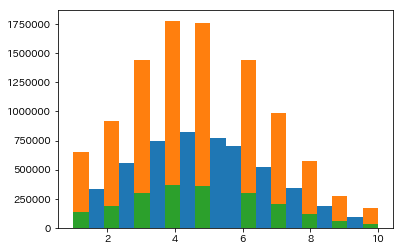

In [9]:
#欠損インデックス
z_vec = Z.reshape(hh*item)
index_z1 = (z_vec==1).nonzero(); index_z1 = np.array(index_z1).reshape(len(index_z1[0]))
index_z0 = (z_vec==0).nonzero(); index_z0 = np.array(index_z0).reshape(len(index_z0[0]))
N = index_z1.shape[0]

#欠損ベクトルに応じてデータを抽出
user_id = user_id0[index_z1]
item_id = item_id0[index_z1]
x = x0[index_z1, :]
y = y0_vec[index_z1]
n1 = pd.DataFrame(user_id)[0].value_counts(sort=False); n1 = np.array(n1.sort_index())
n2 = pd.DataFrame(item_id)[0].value_counts(sort=False); n2 = np.array(n2.sort_index())

#生成した応答変数のヒストグラム
plt.hist(y0, bins=20)
plt.hist(y0_vec, bins=20)
plt.hist(y, bins=20)

In [10]:
####モンテカルロEMアルゴリズムでLRBLFモデルを推定####
##アルゴリズムの設定
LL1 = -1000000000   #対数尤度の初期値
tol = 0.25
iter = 1
dl = 100
L = 500   #モンテカルロサンプリング数

##パラメータの真値
#モデルパラメータの設定
beta = betat
beta_mu = np.dot(x, beta)
sigma = sigmat

#ユーザーベースのパラメータの初期値
sigma_u = sigma_ut
Cov_u = Cov_ut
inv_Cov_u = numpy.linalg.inv(Cov_u)
alpha_u = alpha_ut
theta_mu1 = np.dot(u, alpha_u)
theta_u1 = theta_mu11 = theta_ut1
theta_mu12 = np.delete(theta_mu1, 0, 1)
theta_u2 = theta_ut2

#アイテムベースのパラメータの初期値
sigma_v = sigma_vt
Cov_v = Cov_vt
inv_Cov_v = numpy.linalg.inv(Cov_v)
alpha_v = alpha_vt
theta_mu2 = np.dot(v, alpha_v)
theta_v1 = theta_mu21 = theta_vt1
theta_mu22 = np.delete(theta_mu2, 0, 1)
theta_v2 = theta_vt2

#行列分解の初期値
uv = np.sum(theta_ut2[user_id, :] * theta_vt2[item_id, :], axis=1)

##初期値の設定
#モデルパラメータの設定
beta = np.repeat(0, x.shape[1])
beta_mu = np.dot(x, beta)
sigma = 0.5

#ユーザーベースのパラメータの初期値
sigma_u = 0.2
Cov_u = 0.1 * np.identity(k)
inv_Cov_u = numpy.linalg.inv(Cov_u)
alpha_u = np.zeros((u.shape[1], k+1))
theta_mu1 = np.dot(u, alpha_u)
theta_u1 = theta_mu11 = theta_mu1[:, 1]
theta_mu12 = np.delete(theta_mu1, 0, 1)
theta_u2 = theta_mu12 + numpy.random.multivariate_normal(np.repeat(0, k), Cov_u, hh)

#アイテムベースのパラメータの初期値
sigma_v = 0.2
Cov_v = 0.1 * np.identity(k)
inv_Cov_v = numpy.linalg.inv(Cov_v)
alpha_v = np.zeros((v.shape[1], k+1))
theta_mu2 = np.dot(v, alpha_v)
theta_v1 = theta_mu21 = theta_mu2[:, 1]
theta_mu22 = np.delete(theta_mu2, 0, 1)
theta_v2 = theta_mu22 + numpy.random.multivariate_normal(np.repeat(0, k), Cov_v, item)

#行列分解の初期値
uv = np.sum(theta_u2[user_id, :] * theta_v2[item_id, :], axis=1)

In [11]:
##データの設定
#インデックスの作成
index = np.array(range(y.shape[0]))
user_list = [i for i in range(hh)]
item_list = [j for j in range(item)]
for i in range(hh):
    user_list[i] = index[user_id==i]
for j in range(item):
    item_list[j] = index[item_id==j]
    
#定数を設定
inv_xx = numpy.linalg.inv(np.dot(x.T, x))
inv_uu = numpy.linalg.inv(np.dot(u.T, u))
inv_vv = numpy.linalg.inv(np.dot(v.T, v))

In [12]:
##対数尤度の初期値
Mu = beta_mu + theta_u1[user_id] + theta_v1[item_id] + uv
LL = np.sum(scipy.stats.norm.logpdf(y, Mu, sigma))
LLst = np.sum(scipy.stats.norm.logpdf(y, np.mean(y), np.sqrt(np.var(y))))   #対数尤度の基準値
print(np.round([LL, LLst], 1))

[-1.09859204e+08 -4.44412170e+06]


In [13]:
####モンテカルロEMアルゴリズムをパラメータを推定####
while dl > 0:   #dlがtol以上なら繰り返す
    
    ###モンテカルロEステップで潜在変数をサンプリング
    ##ユーザーのランダム効果をサンプリング
    #データの設定
    u_er = y - beta_mu - theta_v1[item_id] - uv   #ユーザーのランダム効果の誤差

    #事後分布のパラメータを設定
    u_mu = np.repeat(0.0, hh)
    for i in range(hh):
        u_mu[i] = np.mean(u_er[user_list[i]])
    weights = np.power(sigma_u, 2) / (np.power(sigma, 2)/n1 + np.power(sigma_u, 2))   #重み係数
    mu_par = weights*u_mu + (1-weights)*theta_mu11   #事後分布の平均
    tau = np.sqrt(1 / (1/np.power(sigma_u, 2) + n1/np.power(sigma, 2)))   #事後分布の標準誤差         

    #正規分布より事後分布をサンプリング
    theta_mc = np.zeros((hh, L))
    for j in range(L):
        theta_mc[:, j] = np.random.normal(mu_par, tau, hh)
    theta_u1 = np.mean(theta_mc, axis=1)   #モンテカルロ平均
    u1_vars = np.var(theta_mc, axis=1)   #モンテカルロ誤差


    ##アイテムのランダム効果をサンプリング
    #データの設定
    v_er = y - beta_mu - theta_u1[user_id] - uv   #アイテムのランダム効果の誤差

    #事後分布のパラメータを設定
    v_mu = np.repeat(0.0, item)
    for j in range(item):
        v_mu[j] = np.mean(v_er[item_list[j]])
    weights = np.power(sigma_v, 2) / (np.power(sigma, 2)/n2 + np.power(sigma_v, 2))   #重み係数
    mu_par = weights*v_mu + (1-weights)*theta_mu21   #事後分布の平均
    tau = np.sqrt(1 / (1/np.power(sigma_v, 2) + n2/np.power(sigma, 2)))   #事後分布の標準誤差         

    #正規分布より事後分布をサンプリング
    theta_mc = np.zeros((item, L))
    for j in range(L):
        theta_mc[:, j] = np.random.normal(mu_par, tau, item)
    theta_v1 = np.mean(theta_mc, axis=1)   #モンテカルロ平均
    v1_vars = np.var(theta_mc, axis=1)   #モンテカルロ誤差


    ##ユーザーの特徴行列のパラメータをサンプリング
    #データの設定
    theta_u_vec = theta_u1[user_id]; theta_v_vec = theta_v1[item_id]
    uv_er = y - beta_mu - theta_u_vec - theta_v_vec
    u2_vars = np.zeros((k, k))

    #ユーザーごとに特徴ベクトルをサンプリング
    #特徴ベクトルの事後分布のパラメータ
    for i in range(hh):
        index = item_id[user_list[i]]; theta_data = theta_v2[index, :]   #アイテムインデックス
        Xy = (np.dot(theta_data.T, uv_er[user_list[i]])).reshape((k, 1))
        XXV = np.dot(theta_data.T, theta_data) + inv_Cov_u
        inv_XXV = np.linalg.inv(XXV)
        mu = np.dot(inv_XXV, (Xy + np.dot(inv_Cov_u, theta_mu12[i, ].reshape(k, 1)))).reshape(k)

        #多変量正規分布からユーザー特徴ベクトルをサンプリング
        theta_u2_data = np.random.multivariate_normal(mu, np.power(sigma, 2)*inv_XXV, L)
        theta_u2[i, :] = np.mean(theta_u2_data, axis=0)   #モンテカルロ平均
        u2_vars += np.cov(theta_u2_data, rowvar=0)   #モンテカルロ誤差


    ##アイテムの特徴行列のパラメータをサンプリング
    #データの設定
    v2_vars = np.zeros((k, k))

    #ユーザーごとに特徴ベクトルをサンプリング
    #特徴ベクトルの事後分布のパラメータ
    for j in range(item):
        index = user_id[item_list[j]]; theta_data = theta_u2[index, :]   #アイテムインデックス
        Xy = (np.dot(theta_data.T, uv_er[item_list[j]])).reshape((k, 1))
        XXV = np.dot(theta_data.T, theta_data) + inv_Cov_v
        inv_XXV = np.linalg.inv(XXV)
        mu = np.dot(inv_XXV, (Xy + np.dot(inv_Cov_v, theta_mu22[j, ].reshape(k, 1)))).reshape(k)

        #多変量正規分布からユーザー特徴ベクトルをサンプリング
        theta_v2_data = np.random.multivariate_normal(mu, np.power(sigma, 2)*inv_XXV, L)
        theta_v2[j, :] = np.mean(theta_v2_data, axis=0)   #モンテカルロ平均
        v2_vars += np.cov(theta_v2_data, rowvar=0)   #モンテカルロ誤差


    ##Mステップで完全データの尤度を最大化
    #行列分解のパラメータ
    uv = np.sum(theta_u2[user_id, :] * theta_v2[item_id, :], axis=1)

    ##素性ベクトルのパラメータを更新
    y_er = y - theta_u_vec - theta_v_vec - uv   #応答変数の設定
    beta = np.dot(inv_xx, np.dot(x.T, y_er))   #最小二乗法で素性ベクトルを更新
    beta_mu = np.dot(x, beta)   #素性ベクトルの平均構造

    #観測モデルの誤差パラメータを更新
    er = y - beta_mu - theta_u_vec - theta_v_vec - uv   
    sigma = np.std(er)


    ##階層モデルのパラメータを更新
    #ユーザーのランダム効果の階層モデルを更新
    alpha_u[:, 0] = np.dot(inv_uu, np.dot(u.T, theta_u1))
    theta_mu11 = np.dot(u, alpha_u[:, 0])
    sigma_u = np.sqrt((sum(u1_vars) + np.sum(np.power(theta_u1 - theta_mu11, 2))) / hh)

    #アイテムのランダム効果の階層モデルを更新
    alpha_v[:, 0] = np.dot(inv_vv, np.dot(v.T, theta_v1))
    theta_mu21 = np.dot(v, alpha_v[:, 0])
    sigma_v = np.sqrt((sum(v1_vars) + np.sum(np.power(theta_v1 - theta_mu21, 2))) / item)

    #ユーザー特徴行列の階層モデルのパラメータを更新
    ind = np.ones(k+1, dtype=bool); ind[0] = False
    alpha_u[:, ind] = np.dot(inv_uu, np.dot(u.T, theta_u2))
    theta_mu12 = np.dot(u, alpha_u[:, ind])
    Cov_u = (u2_vars + np.dot((theta_u2 - theta_mu12).T, (theta_u2 - theta_mu12))) / hh
    inv_Cov_u = np.linalg.inv(Cov_u)

    #アイテムの特徴行列の階層モデルのパラメータを更新
    alpha_v[:, ind] = np.dot(inv_vv, np.dot(v.T, theta_v2))
    theta_mu22 = np.dot(v, alpha_v[:, ind])
    Cov_v = (v2_vars + np.dot((theta_v2 - theta_mu22).T, (theta_v2 - theta_mu22))) / item
    inv_Cov_v = np.linalg.inv(Cov_v)

    ##アルゴリズムの収束判定
    Mu = beta_mu + theta_u_vec + theta_v_vec + uv   #完全データの平均ベクトル
    LL = np.sum(scipy.stats.norm.logpdf(y, Mu, sigma))   #完全データの対数尤度を更新
    iter = iter + 1
    dl = LL- LL1
    LL1 = LL
    print(np.round([LL, LLst], 1))

[-2837678.5 -4444121.7]
[-2489653.8 -4444121.7]
[-2418699.4 -4444121.7]
[-2405115.5 -4444121.7]
[-2402505.  -4444121.7]
[-2403142.4 -4444121.7]
